In [1]:
import pandas as pd
from keras import Input
from matplotlib import pyplot as plt

from utils.IndicatorGenerator import IndicatorGenerator
from utils.StockDataManager import StockDataManager

In [2]:
stockDataManager = StockDataManager()

df = stockDataManager.history(ticker="MSFT", period="1d", interval="1d")

MSFT 1d


In [3]:
df.head()

,open,high,low,close,adj_close,volume
date,,,,,,
1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800
1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062199,308160000
1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063272,133171200
1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061663,67766400
1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060591,47894400


In [4]:
df['daily_return'] = df['adj_close'].pct_change()

In [5]:
df.head()

,open,high,low,close,adj_close,volume,daily_return
date,,,,,,,
1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800,NaN
1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062199,308160000,0.035712
1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063272,133171200,0.017250
1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061663,67766400,-0.025431
1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060591,47894400,-0.017391


In [6]:
df['daily_return'] = df['daily_return'].fillna(0)
df.head()

,open,high,low,close,adj_close,volume,daily_return
date,,,,,,,
1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800,0.000000
1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062199,308160000,0.035712
1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063272,133171200,0.017250
1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061663,67766400,-0.025431
1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060591,47894400,-0.017391


In [7]:
indicatorGen = IndicatorGenerator(df)
windows = [5, 10, 15, 20, 50, 100, 200]

for window in windows:
    sma = indicatorGen.moving_average(window)
    ema = indicatorGen.exponential_moving_average(window)
    df['EMA_' + str(window)] = ema
    df['SMA_' + str(window)] = sma

df.bfill(inplace=True)
macd, signal = indicatorGen.macd()
df['macd'] = macd
df['signal'] = signal

sma, upper_band, lower_band = indicatorGen.bollinger_bands()
df['bb_upper'] = upper_band
df['bb_lower'] = lower_band

df['rsi'] = indicatorGen.rsi()
df['stochastic_oscillator'] = indicatorGen.stochastic_oscillator()
df['cci'] = indicatorGen.cci()

df.bfill(inplace=True)



In [8]:
df['target'] = df['daily_return'].shift(-1)

In [9]:
df.head()

,open,high,low,close,adj_close,volume,daily_return,EMA_5,SMA_5,EMA_10,...,EMA_200,SMA_200,macd,signal,bb_upper,bb_lower,rsi,stochastic_oscillator,cci,target
date,,,,,,,,,,,,,,,,,,,,,
1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060055,1031788800,0.000000,0.060055,0.061556,0.060055,...,0.060055,0.072028,0.000000,0.000000,0.062935,0.055887,46.666923,-200.310428,35.186403,0.035712
1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062199,308160000,0.035712,0.060769,0.061556,0.060444,...,0.060076,0.072028,0.000171,0.000034,0.062935,0.055887,46.666923,-200.310428,35.186403,0.017250
1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063272,133171200,0.017250,0.061604,0.061556,0.060959,...,0.060108,0.072028,0.000389,0.000105,0.062935,0.055887,46.666923,-200.310428,35.186403,-0.025431
1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061663,67766400,-0.025431,0.061623,0.061556,0.061087,...,0.060123,0.072028,0.000427,0.000169,0.062935,0.055887,46.666923,-200.310428,35.186403,-0.017391
1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060591,47894400,-0.017391,0.061279,0.061556,0.060997,...,0.060128,0.072028,0.000366,0.000209,0.062935,0.055887,46.666923,-200.310428,35.186403,-0.026547


In [10]:
from sklearn.preprocessing import StandardScaler

train_len = int(len(df) * 0.8)
df_train = df[:train_len]
df_test = df[train_len:]

columns = df.columns
scaler = StandardScaler()
scaler.fit(df_train)
df_train[columns] = scaler.transform(df_train)
df_test[columns] = scaler.transform(df_test)


In [11]:
import numpy as np


def create_sequences(sequence_length, data):
    features = data.columns
    target = 'adj_close'
    X = []
    y = []
    x_raw = data[features].values
    y_raw = data[target].values
    for i in range(x_raw.shape[0] - sequence_length):
        X.append(x_raw[i:i + sequence_length])
        y.append(y_raw[i + sequence_length])
    return np.array(X), np.array(y)

In [12]:
X_train, y_train = create_sequences(60, df_train)
X_test, y_test = create_sequences(60, df_test)

In [13]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(X_train.shape[1])

X_train shape: (7659, 60, 29)
X_test shape: (1870, 60, 29)
y_train shape: (7659,)
y_test shape: (1870,)
60


In [14]:
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Conv1D, MaxPooling1D, Flatten, concatenate


def build_model():
    input_layer = Input(shape=(60, df_train.shape[1]))

    # LSTM
    lstm1 = LSTM(units=50, return_sequences=True)(input_layer)
    lstm2 = LSTM(units=50, return_sequences=False)(lstm1)

    # CNN
    cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
    max_pool = MaxPooling1D(pool_size=2)(cnn1)
    flatten = Flatten()(max_pool)

    combined = concatenate([lstm2, flatten])
    dense1 = Dense(units=64, activation='relu')(combined)
    dropout = Dropout(0.5)(dense1)
    output = Dense(1)(dropout)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='mse', optimizer='adam')

    model.summary()

    return model

In [15]:
model = build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 29)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 59, 64)       3776        ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 60, 50)       16000       ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 29, 64)       0           ['conv1d[0][0]']                 
                                                                                              

In [16]:
model.fit(X_train, y_train, epochs=100, batch_size=512, validation_data=(X_test, y_test))

Epoch 1/100
15/15 [==============================] - 13s 92ms/step - loss: 0.6862 - val_loss: 1.8194
Epoch 2/100
15/15 [==============================] - 0s 26ms/step - loss: 0.1595 - val_loss: 11.8832
Epoch 3/100
15/15 [==============================] - 0s 25ms/step - loss: 0.1258 - val_loss: 6.0665
Epoch 4/100
15/15 [==============================] - 0s 24ms/step - loss: 0.1220 - val_loss: 1.9348
Epoch 5/100
15/15 [==============================] - 0s 26ms/step - loss: 0.1175 - val_loss: 2.5646
Epoch 6/100
15/15 [==============================] - 0s 25ms/step - loss: 0.1114 - val_loss: 2.0264
Epoch 7/100
15/15 [==============================] - 0s 24ms/step - loss: 0.1058 - val_loss: 3.3541
Epoch 8/100
15/15 [==============================] - 0s 25ms/step - loss: 0.1055 - val_loss: 2.0520
Epoch 9/100
15/15 [==============================] - 0s 26ms/step - loss: 0.1115 - val_loss: 5.2150
Epoch 10/100
15/15 [==============================] - 0s 27ms/step - loss: 0.1064 - val_loss: 5.86

In [17]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

59/59 [==============================] - 0s 7ms/step


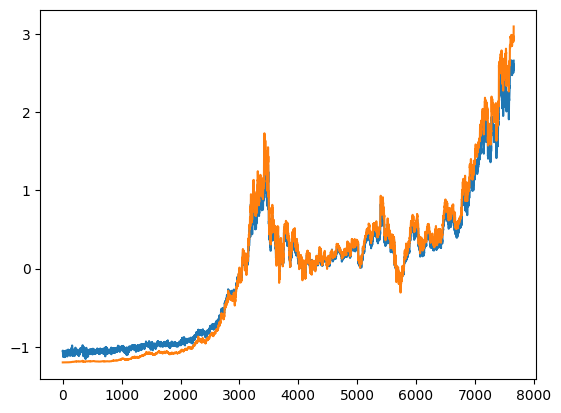

In [19]:
import matplotlib.pyplot as plt
plt.plot(train_predictions)
plt.plot(y_train)

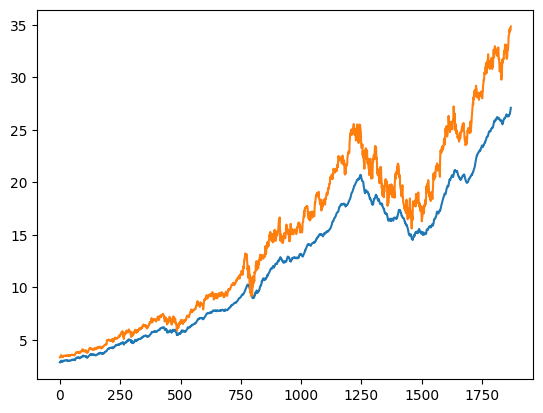

In [20]:
plt.plot(test_predictions)
plt.plot(y_test)